Using the CIFAR10 data provided below, create an alogrithm that takes in a gray scale image and coverts it to a color image.

Note for this problem we will define the grayscale image as the average of the three color channels.

In [1]:
from torchvision.datasets import CIFAR10
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
transform_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=1)
])

transform_color = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

In [3]:
train_data = CIFAR10(root='./datasets', train=True, download=True, transform=transforms.ToTensor())
test_data = CIFAR10(root='./datasets', train=False, download=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_data,batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data,batch_size=64, shuffle=False, pin_memory=True)


100%|██████████| 170498071/170498071 [00:18<00:00, 9214695.44it/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets


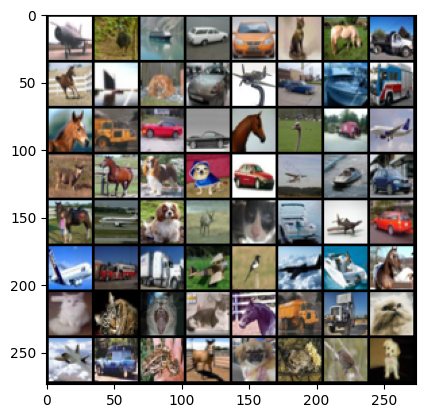

In [4]:
import matplotlib.pyplot as plt
import numpy as np
dataiter = iter(train_loader)
images,_ = next(dataiter)

def show_image(img):
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

show_image(torchvision.utils.make_grid(images))

In [10]:
class CNVC(nn.Module):
  def __init__(self):
      super(CNVC, self).__init__()
      self.color = nn.Sequential(
          nn.Conv2d(1,64,3,1,1),
          nn.ReLU(),
          nn.Conv2d(64,64,3,2,1),
          nn.ReLU(),
          nn.Conv2d(64,128,3,1,1),
          nn.ReLU(),
          nn.Conv2d(128,128,3,2,1),
          nn.ReLU(),
          nn.Conv2d(128,256,3,1,1),
          nn.ReLU(),
          nn.Conv2d(256,256,3,2,1),
          nn.ReLU(),
          nn.Conv2d(256,512,3,1,1),
          nn.ReLU(),
          nn.Conv2d(512,256,3,1,1),
          nn.ReLU(),
          nn.Conv2d(256,128,3,1,1),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='nearest'),
          nn.Conv2d(128,64,3,1, 1),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='nearest'),
          nn.Conv2d(64,32,3,1, 1),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='nearest'),
          nn.Conv2d(32,3,3,1, 1),
          nn.Tanh(),

      )

  def forward(self, x):
      return self.color(x)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


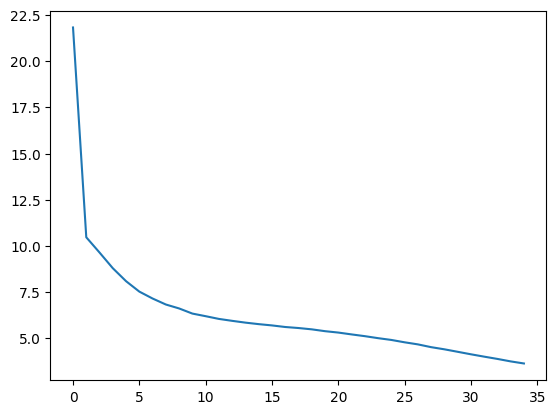

In [29]:
device = torch.device("cuda:0")

cn = CNVC().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(cn.parameters(), lr = 2e-4)
epochs = 35

ls = []
for i in range(epochs):
  total_loss = 0
  for (_,batch) in enumerate(train_loader):
    image = batch[0].to(device)
    grayImage = torch.mean(image, dim=1, keepdim=True)
    output = cn(grayImage)
    loss = criterion(output, image)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()

  print(i)
  ls.append(total_loss)

plt.plot(ls)

In [26]:
def show(img,gr,rim):
    rimg = rim.numpy()
    grimg = gr.numpy()
    npimg = img.numpy()
    plt.imshow(np.transpose(rimg,(1,2,0)))
    plt.show()
    plt.imshow(np.transpose(grimg,(1,2,0)))
    plt.show()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def compareResults(model):
  with torch.no_grad():
    dataiter = iter(train_loader)
    images, _ = next(dataiter)
    grayImages = torch.mean(images, dim=1, keepdim=True).to(device)
    colorized = model(grayImages)
    show(torchvision.utils.make_grid(colorized.to('cpu')),torchvision.utils.make_grid(grayImages.to('cpu')),torchvision.utils.make_grid(images))

def imshow(img,gr,rim):
    rimg = rim.numpy()
    grimg = gr.numpy()
    npimg = img.numpy()
    plt.imshow(np.transpose(rimg,(1,2,0)))
    plt.show()
    plt.imshow(np.transpose(grimg,(1,2,0)))
    plt.show()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

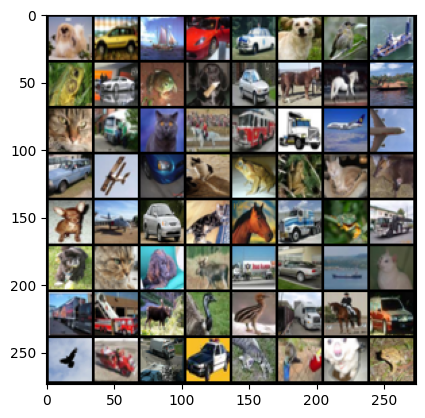

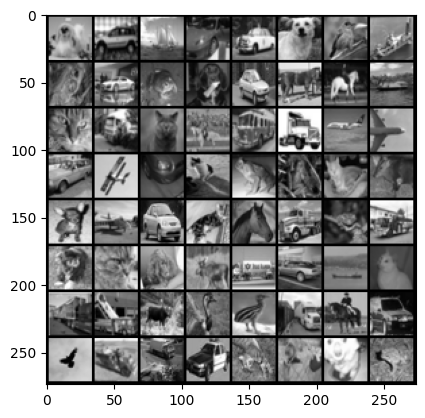

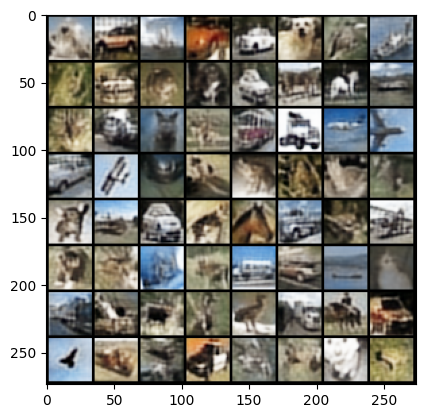

In [30]:
compareResults(cn)

In [20]:
class CNVC2(nn.Module):
  def __init__(self):
      super(CNVC2, self).__init__()

      self.c1 = nn.Conv2d(1,64,4,2,1) #16 * 16
      self.c2 = nn.Conv2d(64,128,4,2,1) # 8*8
      self.c3 = nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1) #4*4
      self.c4 = nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1) #2*2
      self.bn1 = nn.BatchNorm2d(64)
      self.bn2 = nn.BatchNorm2d(128)
      self.bn3 = nn.BatchNorm2d(256)
      self.bn4 = nn.BatchNorm2d(512)


      self.ct1 = nn.ConvTranspose2d(512,256,4,2,1) # 512->256
      self.ct2 = nn.ConvTranspose2d(512,128,4,2,1) # 512->128
      self.ct3 = nn.ConvTranspose2d(256,64,4,2,1) # 256->64
      self.ct4 = nn.ConvTranspose2d(128,32,4,2,1) # 128->32
      self.bdn1 = nn.BatchNorm2d(256)
      self.bdn2 = nn.BatchNorm2d(128)
      self.bdn3 = nn.BatchNorm2d(64)
      self.bdn4 = nn.BatchNorm2d(32)
      self.ct5 = nn.Conv2d(32,3,3,1,1)


  def forward(self, x):
      xe1 = F.leaky_relu(self.bn1(self.c1(x)))
      xe2 = F.leaky_relu(self.bn2(self.c2(xe1)))
      xe3 = F.leaky_relu(self.bn3(self.c3(xe2)))
      xe4 = F.leaky_relu(self.bn4(self.c4(xe3)))

      xd1 = F.leaky_relu(self.bdn1(self.ct1(xe4)))
      xfd1 = torch.cat([xd1,xe3],dim=1) #512
      xd2 = F.leaky_relu(self.bdn2(self.ct2(xfd1)))
      xfd2 = torch.cat([xd2,xe2],dim=1) #256
      xd3 = F.leaky_relu(self.bdn3(self.ct3(xfd2)))
      xfd3 = torch.cat([xd3,xe1],dim=1) #128
      xd4 = F.leaky_relu(self.bdn4(self.ct4(xfd3)))
      o = self.ct5(xd4)
      return F.tanh(o)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


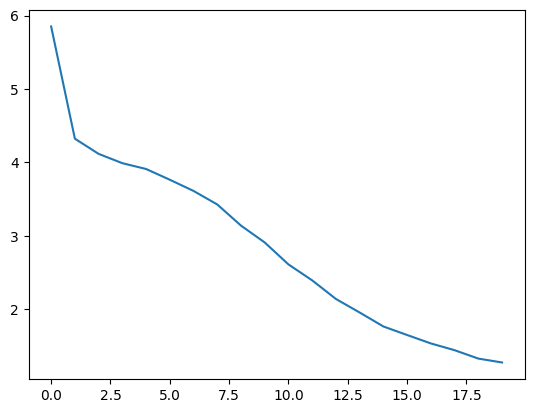

In [23]:
device = torch.device("cuda:0")

cn2 = CNVC2().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(cn2.parameters(), lr = 1e-3)
epochs = 20

lostlist = []
for i in range(epochs):
  total= 0
  for j,batch in enumerate(train_loader):
    images = batch[0].to(device)
    grayImages = torch.mean(images, dim=1, keepdim=True)
    output = cn2(grayImages)
    loss = criterion(output, images)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total = total + loss.item()

  print(i)
  lostlist.append(total)

plt.plot(lostlist)

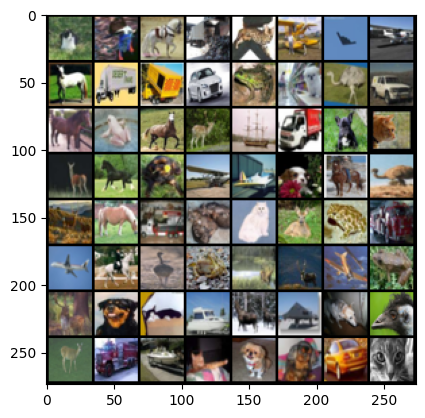

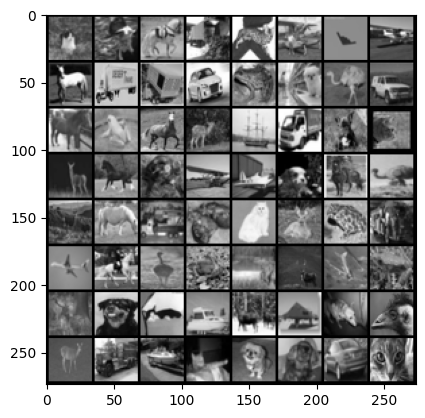

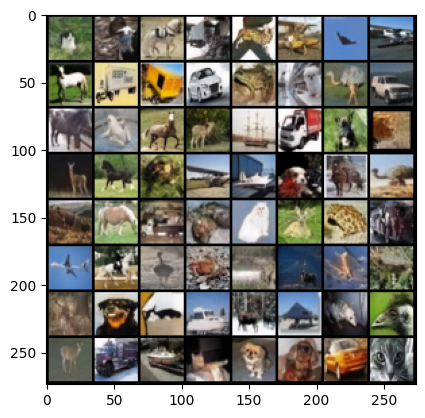

In [28]:
compareResults(cn2)